# RNN-v3

### Updates from v1

Changed the input data to be aligned by time so that all mouse and eye points are more closely aligned together. 

### Updates from v2

Testing data for negative examples had a bug. Corrected this to provide 4 examples per direction per other user. 

Shuffling training data to give a more even distributions of classes per batch. 

In [1]:
import os
import numpy as np
import pandas as pd
from random import randint, shuffle
from keras.layers import Dense, Activation, Input, CuDNNLSTM, Bidirectional, Dropout
from keras.models import Model, Sequential, load_model
from keras.preprocessing.sequence import pad_sequences
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from matplotlib import pyplot

Using TensorFlow backend.


## Helper Function Definitions

### Data Preperation Functions

In [2]:
# Return a list of usernames based on the file names in feature files. 
def get_usernames(train_files):
    usernames = []
    for f in train_files:
        ext = f[-4:]
        if(ext == '.csv'):
            username = f[:f.index('-')]
            usernames.append(username)
    return usernames


# Return a list of Pandas Dataframes from the csv feature files.  
def getdfs(path, files):
    dfs = []
    for f in files: 
        ext = f[-4:]
        if(ext == '.csv'):
            file = os.path.join(path, f)
            df = pd.read_csv(file)
            dfs.append(df)
    return dfs



# Build training and testing sets from positive and negative examples.  
# Take the examples and create a sequence from each sample in a given direction. Combines positive and negative examples
# and returns a NP array for the X values and Y values. 
# X is a 3D tensor of (number of samples x sample length x feature length)
# Sequences are padded to provide equal-length samples for the entire set of samples. 
def create_train_test_set(username, usernames, dfs, isTrain):
    
    # Create the positive examples. Set y to 1
    useridx = usernames.index(username)
    user_df = dfs[useridx]
    pos_sequences = create_sequences(user_df)
    
    # Copy the positive examples a few times to provide more positive data per epoch
    if isTrain:
        pos_copy = pos_sequences.copy()
        for _ in range(10):
            pos_sequences += pos_copy
    ys = [1 for _ in pos_sequences]
    
    
    # Get negative examples
    dirs = [1,2,3,4,5,6,7,8]
    neg_sequences = []
    
    for user in usernames:
        if user != username:
            idx = usernames.index(user)
            df = dfs[idx]
            
            # Use all negative examples for training
            if isTrain:
                seqs = create_sequences(df)
                neg_sequences += seqs
            # Use 5 samples in each direction for testing. 
            else:
                for i in dirs:
                    try:
                        dir_i = df.loc[df['Direction'] == i]
                        seqs = create_sequences(dir_i)
                        seqs = [seqs[randint(0, len(seqs) -1)] for x in range(5)]
                        neg_sequences += seqs
                    except KeyError:
                        print("Key Error on Direction:")
                        print(df)

    ys = ys + [0 for _ in neg_sequences]
    pos_neg = pos_sequences + neg_sequences
    x = np.asarray(encode(pad_sequences(pos_neg, maxlen=50, dtype='float32', value=[0 for x in range(10)])))
    y = np.asarray(ys)               
    return x, y


# Create sequences out of a dataframe by splitting the sample number into a 2D array.
# For each sample in a given direction: create a list of the 10 features, and append that list to the sample
# Remove the sample number from the features as this is not important to the classifier. 
    '''
    Goal: [Sample 1: [[10 features], [10 features], [10 features]], Sample 2: [[10 features], [10 features], [10 features]]]
    '''
def create_sequences(df):

    samples = df['Sample'].unique()
    dirs = df['Direction'].unique()
    sequences = []
    for dir in dirs:
        dir_frame = df.loc[df['Direction'] == dir]
        for sample in samples:
            sample_frame = dir_frame.loc[dir_frame['Sample'] == sample]
            sf = sample_frame.drop(columns=['Sample']) # Remove the sample number before adding to the list
            values = list(sf.values.tolist())
            if len(values) > 0:
                sequences.append(values)
    return sequences

# encode each of the features with a one hot encoding for the direction variable
def encode(x):
    newx = []
    for sequence in x:
        new_seq = []
        for feature in sequence:
            new_seq.append(one_hot_encode(feature))
        newx.append(new_seq)
    return newx

# One hot encode the direction variable only.
# The direction is the first variable in the feature vec, so base the one hot encoding on this. 
# If the direction value is 0 (used for padding only) then use all zeros not an encoding
def one_hot_encode(feature_vec):
    feature_vec = list(feature_vec)
    zeros = [0, 0, 0, 0, 0, 0, 0, 0]
    n_labels = 8
    i = np.eye(n_labels)
    
    dir = feature_vec[0]
    if dir < 1:
        enc = zeros
    else:
        enc = i[int(feature_vec[0]) - 1]

    feature_vec.remove(feature_vec[0])

    feature_vec[0:0] = enc
    return feature_vec

# Randomly shuffle the data for input into the neural network. 
# Shuffle X and Y in the same ordering.
# Return shuffled X, Y
def shuffle_data(X, Y):
    idxs = [x for x in range(len(X))]
    shuffle(idxs)
    Xnew = X[idxs, :,:]
    Ynew = Y[idxs,]
    return Xnew, Ynew

### Model Accuracy Functions

In [3]:
# convert the probabilities to predictions on a threshold
def convert(p, threshold):
    return 1 if p >= threshold else 0

# Given a set of probabilities and true Y-Values, 
# Convert probabilities to predictions. 
# Determine accuracy and return dictionary with tracked metrics. 
def calc_accuracy_metrics(y_pred, y_actual, threshold):
    preds = [convert(y, threshold) for y in y_pred]
    pairs = list(zip(preds, y_actual))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for pair in pairs:
        if pair[0] == 1:
            if pair[1] == 1:
                tp += 1
            else:
                fp += 1
        else:
            if pair[1] == 0:
                tn += 1
            else:
                fn += 1
    
    try:
        far = fp / (fp + tn)
    except ZeroDivisionError:
        far = -1
    try:    
        frr = fn / (fn + tp)
    except ZeroDivisionError:
        frr = -1
    try:    
        precision = tp / (tp + fp)
    except ZeroDivisionError:
        precision = -1
    try:
        recall = tp / (tp + fn)
    except ZeroDivisionError:
        recall = -1
    try:    
        f1_score = (2 * precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1_score = -1
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    performance_results = {'far': far, 'frr': frr, 'precision': precision, 'recall': recall, 'f1': f1_score, 
                           'accuracy': accuracy}
    return performance_results


def get_batch_predictions(clf, test_set):
    dirs = [1,2,3,4,5,6,7,8]
    pos_ex = test_set[test_set['Y-Value'] == 1]
    neg_ex = test_set[test_set['Y-Value'] == 0]
    
    direction_pos = []
    direction_neg = []
    
    for dir in dirs:
        dir_i = pos_ex[pos_ex['Direction'] == dir]
        dir_i_neg = neg_ex[neg_ex['Direction'] == dir]
        direction_pos.append(dir_i)
        direction_neg.append(dir_i_neg)
    
    # Create Positive Batches and get per batch predictions
    pos_batch_predictions = []
    done = False
    batch_count = 0
    while not done:
        batch = []
        for i in range(8):
            # Find the number of rows in this data frame
            length = direction_pos[i].shape[0]
            # We are grouping 4 examples per direction in a batch. 
            # So start at batch count * 4
            start = batch_count * 4
            
            # If there are less than 4 unused examples remaining just grab the remaining ones
            if length - start < 4:
                end = start + length % 4
            # Otherwise grab 4 examples.
            else:
                end = start + 4
            
            # If there are examples to add, add them.
            if length - start > 0:
                examples = direction_pos[i].iloc[start:end]
                batch.append(examples)
                
        # If there were examples added into this batch, get the average prediction on the batch.
        # Otherwise, mark done as true. 
        if len(batch) > 0:
            df = pd.concat(batch)
            p = predict_batch(df, clf)
            pos_batch_predictions.append(p)
            batch_count += 1
        else:
            done = True
            
    # Create Negative Batches and get per batch predictions
    # Do the same thing as above.
    neg_batch_predictions = []
    done = False
    batch_count = 0
    while not done:
        batch = []
        for i in range(8):
            length = direction_neg[i].shape[0]
            start = batch_count * 4
            if length - start < 4:
                end = start + length % 4
            else:
                end = start + 4
            
            if length - start > 0:
                examples = direction_neg[i].iloc[start:end]
                batch.append(examples)
                 
        if len(batch) > 0:
            df = pd.concat(batch)
            p = predict_batch(df, clf)
            neg_batch_predictions.append(p)
            batch_count += 1
        else:
            done = True
                      
    return pos_batch_predictions, neg_batch_predictions


def predict_batch(batch, clf):
    x, y = prepare_data(batch)
    y_preds = clf.predict(x, verbose=False)
    avg = sum(y_preds.flatten()) / len(y_preds.flatten())
    return avg


def test_batches(clf, test_set, p_threshold):
    pos_preds, neg_preds = get_batch_predictions(clf, test_set)
    
    preds = []
    true_ys = []
    for i in range(len(pos_preds)):
        preds.append(pos_preds[i])
        true_ys.append(1)
    for i in range(len(neg_preds)):
        preds.append(neg_preds[i])
        true_ys.append(0)
    
    performance_results = calc_accuracy_metrics(preds, true_ys, p_threshold)
    return performance_results

## Create the training and test sets.

Training and testing sets are composed of 50% of the users data. 

In [4]:
# Create Global Constants to be used. 
# Usernames, Train and Test sets for each user. 

train_path = os.path.join(os.getcwd(), 'RNN-Train-Aligned')
test_path = os.path.join(os.getcwd(), 'RNN-Test-Aligned')
model_save_path = os.path.join(os.getcwd(), 'RNNv3-saved_models')

train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

usernames = get_usernames(train_files)
train_dfs = getdfs(train_path, train_files)
test_dfs = getdfs(test_path, test_files)

col_labels = ['Direction', 'Sample', 'Sep', 'Mouse Speed', 'Eye Speed', 'Mouse Angle', 'Eye Angle', 'Mouse I-Angle', 'Eye I-Angle',
              'Mouse Region', 'Eye Region', 'Y-Value']

training_xs = []
training_ys = []
testing_xs = []
testing_ys = []
for user in usernames:
    x, y = create_train_test_set(user, usernames, train_dfs, isTrain=True)
    xtrain, ytrain = shuffle_data(x, y)
    training_xs.append(xtrain)
    training_ys.append(ytrain)
    x, y = create_train_test_set(user, usernames, test_dfs, isTrain=False)
    xtest, ytest = shuffle_data(x, y)
    testing_xs.append(xtest)
    testing_ys.append(ytest)

## Model Creation and Testing Definitions

## Best Architecture

#### This was found to be the best model on past tests. Using this from now on. 

Add another LSTM layer with additional dropout. 

In [43]:
# Build the RNN 
# Input - Sequence of 17 dimensional feature vector

def create_rnn_model(X, Y, test_x, test_y, path_to_save):
    xshape = X.shape
    samples = xshape[0]
    timesteps = xshape[1]
    featurelen = xshape[2]
    
    clf = Sequential()
    clf.add(Bidirectional(CuDNNLSTM(50, input_shape=(timesteps, featurelen), kernel_initializer='glorot_uniform', return_sequences=True)))
    clf.add(CuDNNLSTM(50, kernel_initializer='glorot_uniform', return_sequences=False))
    clf.add(Dropout(0.15))
    clf.add(Dense(50, kernel_initializer= 'glorot_uniform', activation='relu'))
    clf.add(Dropout(0.25))
    clf.add(Dense(32, kernel_initializer= 'glorot_uniform', activation='relu'))
    clf.add(Dropout(0.15))
    clf.add(Dense(1, kernel_initializer= 'glorot_uniform', activation='sigmoid'))
    clf.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    # Add callbacks and train
    earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=2, verbose=0, mode='auto')
    history = clf.fit(X, Y, batch_size = 20, epochs=5, callbacks=[earlystop], validation_data=(test_x, test_y), verbose=0)

    
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('Train vs Validation Loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('Epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()
    # Save Model
    clf.save(path_to_save)
    return clf

In [6]:
def test_rnn(clf, test_x, test_y, p_thresh):
    ypreds = clf.predict(test_x, batch_size=10, verbose=False)
    performance = calc_accuracy_metrics(ypreds.flatten(), test_y, p_thresh)
    return performance

## Build a model for each user and test accuracy

### Amanda 11: 

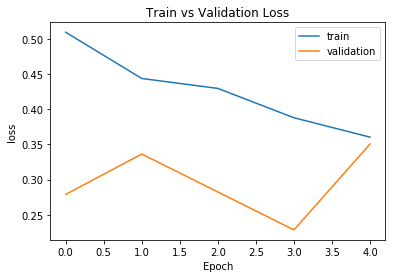

far : 0.19516129032258064
frr : 0.20353982300884957
precision : 0.2710843373493976
recall : 0.7964601769911505
f1 : 0.4044943820224719
accuracy : 0.804138950480414


In [44]:
train_x = training_xs[0]
train_y = training_ys[0]
test_x = testing_xs[0]
test_y = testing_ys[0]
username = usernames[0]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Amelia1: 

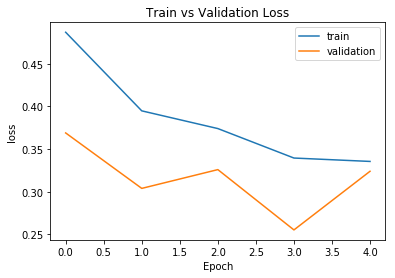

far : 0.16129032258064516
frr : 0.48314606741573035
precision : 0.18699186991869918
recall : 0.5168539325842697
f1 : 0.27462686567164174
accuracy : 0.8171557562076749


In [50]:
train_x = training_xs[1]
train_y = training_ys[1]
test_x = testing_xs[1]
test_y = testing_ys[1]
username = usernames[1]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Andy1: 

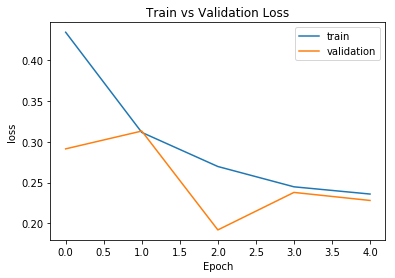

far : 0.09274193548387097
frr : 0.25
precision : 0.39473684210526316
recall : 0.75
f1 : 0.5172413793103448
accuracy : 0.8955223880597015


In [51]:
train_x = training_xs[2]
train_y = training_ys[2]
test_x = testing_xs[2]
test_y = testing_ys[2]
username = usernames[2]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Andy21: 

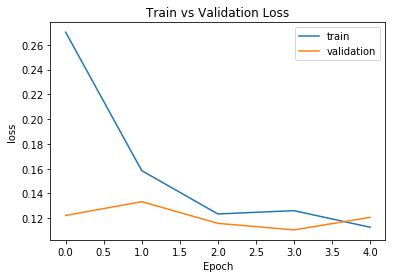

far : 0.03225806451612903
frr : 0.68
precision : 0.16666666666666666
recall : 0.32
f1 : 0.2191780821917808
accuracy : 0.9549407114624506


In [41]:
train_x = training_xs[3]
train_y = training_ys[3]
test_x = testing_xs[3]
test_y = testing_ys[3]
username = usernames[3]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Benjamin1: 

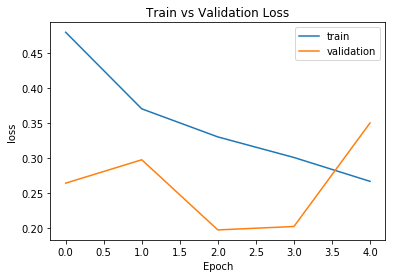

far : 0.18870967741935485
frr : 0.22727272727272727
precision : 0.2251655629139073
recall : 0.7727272727272727
f1 : 0.34871794871794876
accuracy : 0.8087349397590361


In [53]:
train_x = training_xs[4]
train_y = training_ys[4]
test_x = testing_xs[4]
test_y = testing_ys[4]
username = usernames[4]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Blair1: 

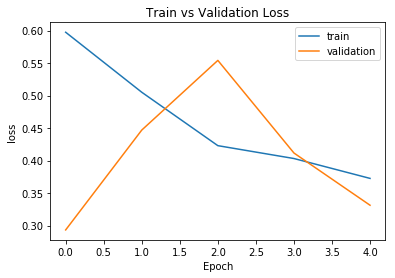

far : 0.08709677419354839
frr : 0.616822429906542
precision : 0.2751677852348993
recall : 0.38317757009345793
f1 : 0.3203125
accuracy : 0.8708240534521158


In [54]:
train_x = training_xs[5]
train_y = training_ys[5]
test_x = testing_xs[5]
test_y = testing_ys[5]
username = usernames[5]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Blake1

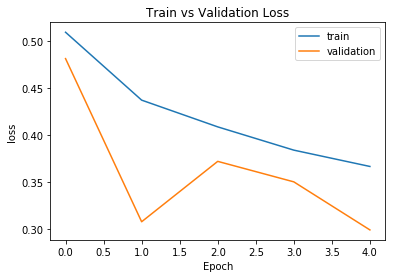

far : 0.0814516129032258
frr : 0.6989247311827957
precision : 0.21705426356589147
recall : 0.3010752688172043
f1 : 0.2522522522522523
accuracy : 0.8754688672168042


In [56]:
username = usernames[6]
train_x = training_xs[6]
train_y = training_ys[6]
test_x = testing_xs[6]
test_y = testing_ys[6]


# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Chloe1

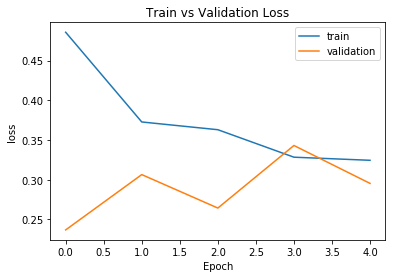

far : 0.1879032258064516
frr : 0.33
precision : 0.22333333333333333
recall : 0.67
f1 : 0.335
accuracy : 0.8014925373134328


In [57]:
username = usernames[7]
train_x = training_xs[7]
train_y = training_ys[7]
test_x = testing_xs[7]
test_y = testing_ys[7]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Connor1

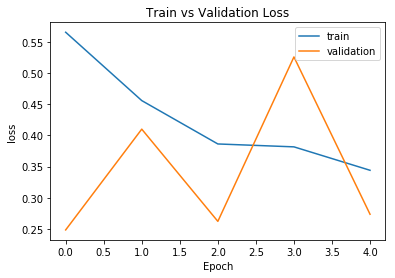

far : 0.0814516129032258
frr : 0.47058823529411764
precision : 0.38414634146341464
recall : 0.5294117647058824
f1 : 0.4452296819787986
accuracy : 0.8844738778513613


In [58]:
username = usernames[8]
train_x = training_xs[8]
train_y = training_ys[8]
test_x = testing_xs[8]
test_y = testing_ys[8]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    


### Cormac1

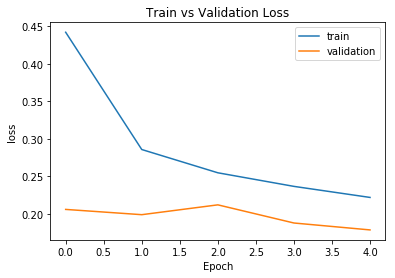

far : 0.03870967741935484
frr : 0.42696629213483145
precision : 0.5151515151515151
recall : 0.5730337078651685
f1 : 0.5425531914893618
accuracy : 0.9352896914973664


In [59]:
username = usernames[9]
train_x = training_xs[9]
train_y = training_ys[9]
test_x = testing_xs[9]
test_y = testing_ys[9]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    


### David1

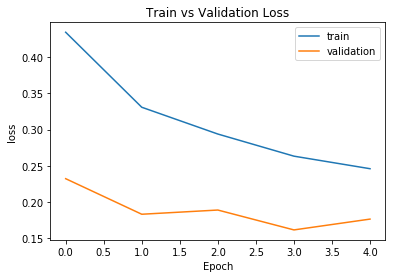

far : 0.062096774193548386
frr : 0.29411764705882354
precision : 0.43795620437956206
recall : 0.7058823529411765
f1 : 0.5405405405405406
accuracy : 0.9230188679245283


In [60]:
username = usernames[10]
train_x = training_xs[10]
train_y = training_ys[10]
test_x = testing_xs[10]
test_y = testing_ys[10]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Graham1: 

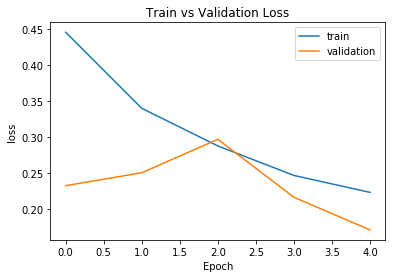

far : 0.041935483870967745
frr : 0.36666666666666664
precision : 0.5229357798165137
recall : 0.6333333333333333
f1 : 0.5728643216080402
accuracy : 0.9360902255639098


In [61]:
train_x = training_xs[11]
train_y = training_ys[11]
test_x = testing_xs[11]
test_y = testing_ys[11]
username = usernames[11]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Hildigerr: 

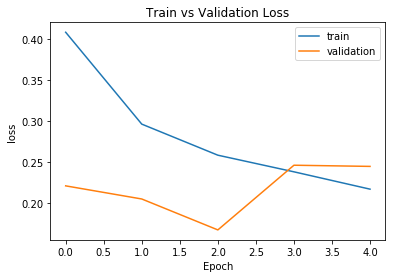

far : 0.13951612903225807
frr : 0.0847457627118644
precision : 0.38434163701067614
recall : 0.9152542372881356
f1 : 0.5413533834586466
accuracy : 0.8652430044182622


In [62]:
train_x = training_xs[12]
train_y = training_ys[12]
test_x = testing_xs[12]
test_y = testing_ys[12]
username = usernames[12]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Ian1

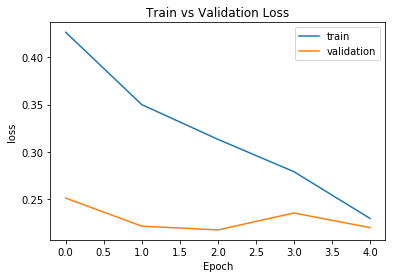

far : 0.05403225806451613
frr : 0.5728155339805825
precision : 0.3963963963963964
recall : 0.42718446601941745
f1 : 0.411214953271028
accuracy : 0.9061801935964259


In [63]:
username = usernames[13]
train_x = training_xs[13]
train_y = training_ys[13]
test_x = testing_xs[13]
test_y = testing_ys[13]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Ian2

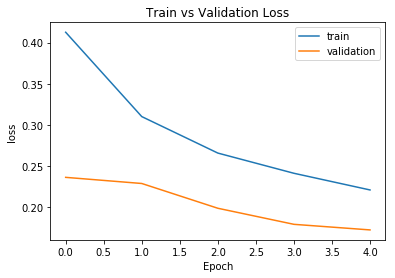

far : 0.06612903225806452
frr : 0.3163265306122449
precision : 0.44966442953020136
recall : 0.6836734693877551
f1 : 0.5425101214574898
accuracy : 0.9155455904334828


In [64]:
username = usernames[14]
train_x = training_xs[14]
train_y = training_ys[14]
test_x = testing_xs[14]
test_y = testing_ys[14]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    


### Jacob1

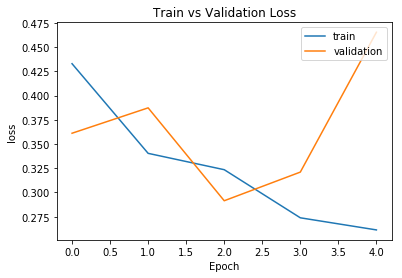

far : 0.2879032258064516
frr : 0.13
precision : 0.19594594594594594
recall : 0.87
f1 : 0.3198529411764706
accuracy : 0.7238805970149254


In [65]:
username = usernames[15]
train_x = training_xs[15]
train_y = training_ys[15]
test_x = testing_xs[15]
test_y = testing_ys[15]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Jake1: 

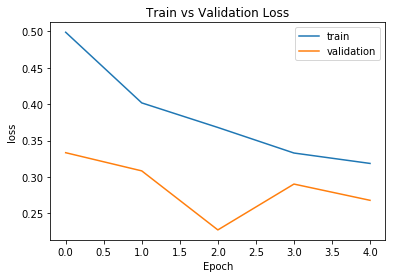

far : 0.1032258064516129
frr : 0.37
precision : 0.3298429319371728
recall : 0.63
f1 : 0.43298969072164945
accuracy : 0.8768656716417911


In [66]:
train_x = training_xs[16]
train_y = training_ys[16]
test_x = testing_xs[16]
test_y = testing_ys[16]
username = usernames[16]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### James1: 

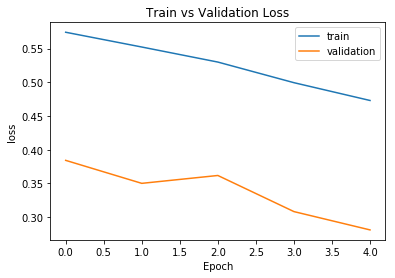

far : 0.041935483870967745
frr : 0.8210526315789474
precision : 0.2463768115942029
recall : 0.17894736842105263
f1 : 0.20731707317073172
accuracy : 0.9026217228464419


In [44]:
train_x = training_xs[17]
train_y = training_ys[17]
test_x = testing_xs[17]
test_y = testing_ys[17]
username = usernames[17]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Jamison1

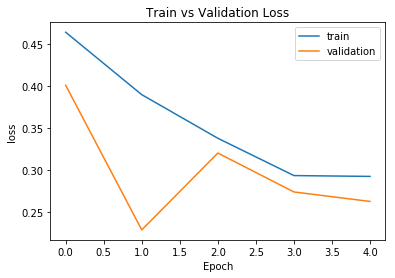

far : 0.13306451612903225
frr : 0.3431372549019608
precision : 0.28879310344827586
recall : 0.6568627450980392
f1 : 0.4011976047904191
accuracy : 0.8509687034277198


In [68]:
username = usernames[18]
train_x = training_xs[18]
train_y = training_ys[18]
test_x = testing_xs[18]
test_y = testing_ys[18]


# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### John1

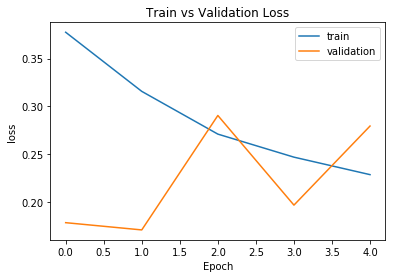

far : 0.15645161290322582
frr : 0.15463917525773196
precision : 0.2971014492753623
recall : 0.845360824742268
f1 : 0.43967828418230553
accuracy : 0.843679880329095


In [69]:
username = usernames[19]
train_x = training_xs[19]
train_y = training_ys[19]
test_x = testing_xs[19]
test_y = testing_ys[19]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Jonah1

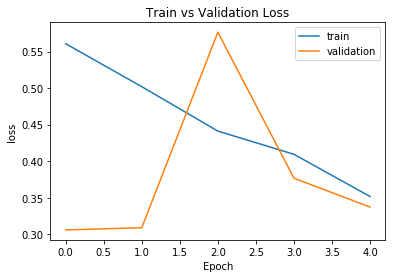

far : 0.14919354838709678
frr : 0.3252032520325203
precision : 0.30970149253731344
recall : 0.6747967479674797
f1 : 0.4245524296675192
accuracy : 0.83492296404989


In [7]:
username = usernames[20]
train_x = training_xs[20]
train_y = training_ys[20]
test_x = testing_xs[20]
test_y = testing_ys[20]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')


### Joseph1: 

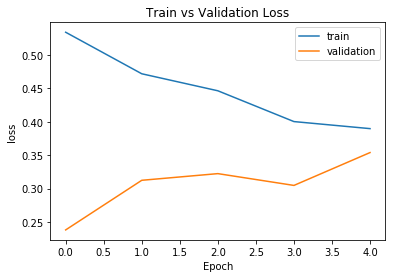

far : 0.21129032258064517
frr : 0.3146067415730337
precision : 0.18885448916408668
recall : 0.6853932584269663
f1 : 0.29611650485436897
accuracy : 0.781790820165538


In [8]:
train_x = training_xs[21]
train_y = training_ys[21]
test_x = testing_xs[21]
test_y = testing_ys[21]
username = usernames[21]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Kevin1: 

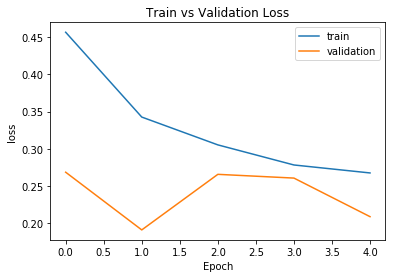

far : 0.10483870967741936
frr : 0.3
precision : 0.3010752688172043
recall : 0.7
f1 : 0.4210526315789474
accuracy : 0.8833333333333333


In [9]:
train_x = training_xs[22]
train_y = training_ys[22]
test_x = testing_xs[22]
test_y = testing_ys[22]
username = usernames[22]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Koji11: 

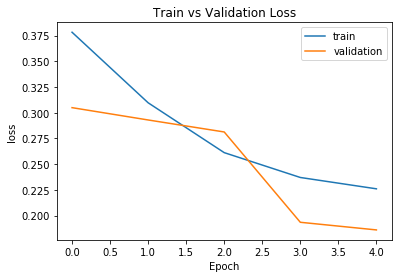

far : 0.03467741935483871
frr : 0.5411764705882353
precision : 0.47560975609756095
recall : 0.4588235294117647
f1 : 0.46706586826347307
accuracy : 0.9328301886792453


In [10]:
train_x = training_xs[23]
train_y = training_ys[23]
test_x = testing_xs[23]
test_y = testing_ys[23]
username = usernames[23]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Leon1: 

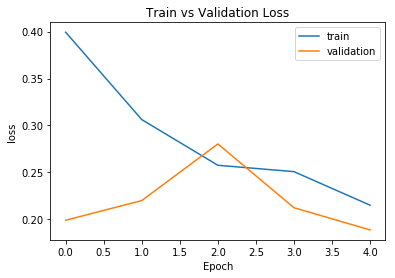

far : 0.04435483870967742
frr : 0.44036697247706424
precision : 0.5258620689655172
recall : 0.5596330275229358
f1 : 0.5422222222222222
accuracy : 0.9236471460340994


In [11]:
train_x = training_xs[24]
train_y = training_ys[24]
test_x = testing_xs[24]
test_y = testing_ys[24]
username = usernames[24]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Michael Mosin1: 

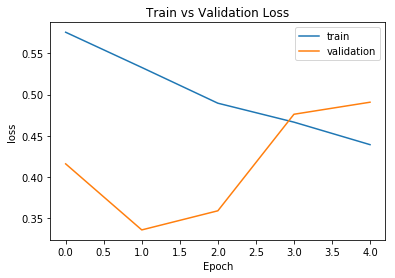

far : 0.27903225806451615
frr : 0.5413533834586466
precision : 0.14987714987714987
recall : 0.45864661654135336
f1 : 0.22592592592592592
accuracy : 0.6955571740713765


In [12]:
train_x = training_xs[25]
train_y = training_ys[25]
test_x = testing_xs[25]
test_y = testing_ys[25]
username = usernames[25]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Mike1: 

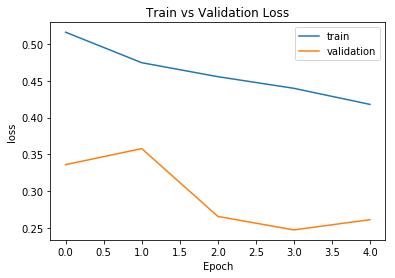

far : 0.0008064516129032258
frr : 1.0
precision : 0.0
recall : 0.0
f1 : -1
accuracy : 0.9267015706806283


In [13]:
train_x = training_xs[26]
train_y = training_ys[26]
test_x = testing_xs[26]
test_y = testing_ys[26]
username = usernames[26]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Phil1: 

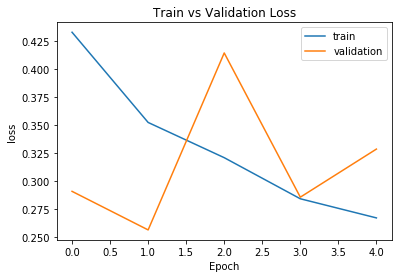

far : 0.12016129032258065
frr : 0.41379310344827586
precision : 0.255
recall : 0.5862068965517241
f1 : 0.35540069686411146
accuracy : 0.8605877920120573


In [14]:
train_x = training_xs[27]
train_y = training_ys[27]
test_x = testing_xs[27]
test_y = testing_ys[27]
username = usernames[27]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Reid1: 

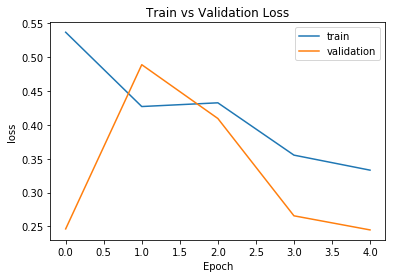

far : 0.08870967741935484
frr : 0.39759036144578314
precision : 0.3125
recall : 0.6024096385542169
f1 : 0.411522633744856
accuracy : 0.891912320483749


In [15]:
train_x = training_xs[28]
train_y = training_ys[28]
test_x = testing_xs[28]
test_y = testing_ys[28]
username = usernames[28]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### SamP1

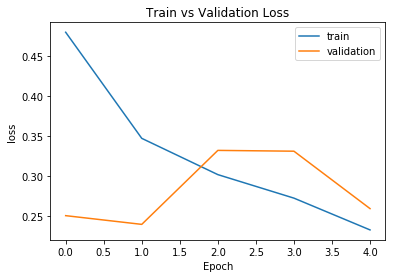

far : 0.06935483870967742
frr : 0.6095238095238096
precision : 0.3228346456692913
recall : 0.3904761904761905
f1 : 0.35344827586206895
accuracy : 0.8884758364312267


In [16]:
username = usernames[29]
train_x = training_xs[29]
train_y = training_ys[29]
test_x = testing_xs[29]
test_y = testing_ys[29]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Sean1: 

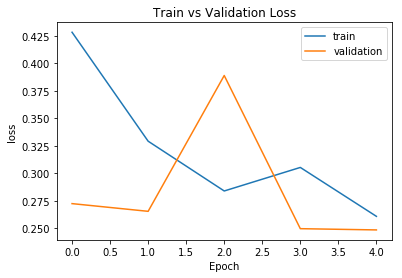

far : 0.11370967741935484
frr : 0.25
precision : 0.37333333333333335
recall : 0.75
f1 : 0.4985163204747775
accuracy : 0.875


In [17]:
train_x = training_xs[30]
train_y = training_ys[30]
test_x = testing_xs[30]
test_y = testing_ys[30]
username = usernames[30]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    

### Theo1

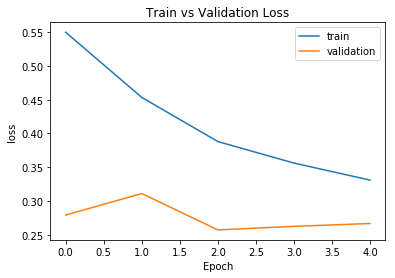

far : 0.08951612903225807
frr : 0.4392523364485981
precision : 0.3508771929824561
recall : 0.5607476635514018
f1 : 0.4316546762589928
accuracy : 0.882702301410542


In [18]:
username = usernames[31]
train_x = training_xs[31]
train_y = training_ys[31]
test_x = testing_xs[31]
test_y = testing_ys[31]

# Create first model
filename = username + '_model.h5'
userfile = os.path.join(model_save_path, filename)
model = create_rnn_model(train_x, train_y, test_x, test_y, userfile)
accuracy = test_rnn(model, test_x, test_y, 0.5)
for k, v in accuracy.items():
    print(f'{k} : {v}')
    